# Overview

This Jupyter Notebook report shows an application of the wide and deep learning model proposed by Google. The wide and deep model consists of two parts: a linear classifier with ReLU as the activation function (wide), and a feed-forward neural network (deep). The purpose of combining these two models is to make use of the advantages of both models: wide for memorization and deep for generalization. In this report, I will be doing a financial data trend prediction using partial data from the [NASDAQ 100 stock dataset](http://cseweb.ucsd.edu/~yaq007/nasdaq100.zip). The following of this report will walk through all the process from data preparation, neural network construction and result evaluation. 

# Data Preparation

First of all, import all necessary python packages such as tensorflow and numpy. The matplotlib was also imported in order to visualize the trend of the data. 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

The dataset file was provided as a local text file with the name "aal.txt". Import the dataset file and extract the data

In [2]:
#from google.colab import files
FILE_NAME = 'aal.txt'
#if not tf.gfile.Exists(FILE_NAME):
#  uploaded = files.upload()

In [3]:
with open(FILE_NAME, 'r') as fid:
  lines = fid.readlines()
  
lines = [line.split('\r')[0] for line in lines]
lines = [line.split('\n')[0] for line in lines]
while '' in lines:
  lines.remove('')
data = np.asarray(list(map(float, lines)))
data

array([35.98  , 35.931 , 35.9044, ..., 48.53  , 48.56  , 48.56  ])

Plot the data to visualize the trend

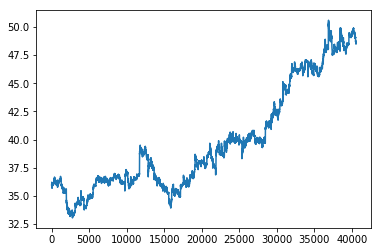

In [4]:
plt.plot(data)
plt.show()

# Data Preprocessing

Before building up the neural network and feeding the data into the network, I split the data into training and testing sets. Three quarters of all the data were used for training and the rest quarter were used for testing and evaluating. 

In [5]:
data_length = len(data)
train_length = int(0.75 * data_length)
test_length = data_length - train_length
train_data = data[:train_length]
test_data = data[train_length:data_length]

Since the goal of this project is to predict the trend from looking at a certain time interval of data, I classified the data into two classes: increasing (represented as class 1) and decreasing (represented as class 0). The flattened train data is reshaped into many groups of data segments with length 60, representing the data within 60 minutes. The predicted trend of the financial data is the trend in the past 60 minutes. Finally, I converted the class labels to one-hot encoded vectors. 

In [6]:
train_data_norm = (train_data - np.mean(train_data)) / np.std(train_data)
test_data_norm = (test_data - np.mean(test_data)) / np.std(test_data)

# Reshape and prepare for the training data and labels
window_size = 60
X_train = train_data_norm.reshape(-1, window_size)
train_labels = np.sign(X_train[:,-1] - X_train[:,0])

# Convert the two-class labels to one-hot encoded vectors
train_labels[np.where(train_labels==-1)] = 0
y_train_onehot = np.eye(2)[train_labels.astype(int)]

# Reshape and prepare for the testing data and labels
X_test = test_data_norm.reshape(-1, window_size)
test_labels = np.sign(X_test[:,-1] - X_test[:,0])

# Convert the two-class labels to one-hot encoded vectors
test_labels[np.where(test_labels==-1)] = 0
y_test_onehot = np.eye(2)[test_labels.astype(int)]

# Construct the Neural Network

The wide and deep neural network was built using keras. 

In [7]:
from keras.models import Model, Input
from keras.layers.merge import add, concatenate
from keras.layers import Dense

Using TensorFlow backend.


The wide neural network was a simple linear classifier with ReLU activation function. The input layer has 60 nodes representing time series data within 60 minutes. 

In [8]:
# Wide
common_input = Input(shape=X_train[1].shape, name='common_input')
wide_out = Dense(2, activation='relu', name='wide_out')(common_input)
wide_model = Model(inputs=common_input, outputs=wide_out)
wide_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
common_input (InputLayer)    (None, 60)                0         
_________________________________________________________________
wide_out (Dense)             (None, 2)                 122       
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


The deep neural network was a feed-forward neural network with 2 hidden layers with 125 nodes and 50 nodes, and 1 output layer with 2 nodes representing 2 classes. Each layer has a ReLU activation function

In [9]:
# Deep
deep1 = Dense(125, activation='relu', name='deep1')(common_input)
deep2 = Dense(50, activation='relu', name='deep2')(deep1)
deep_out = Dense(2, activation='relu', name='deep_out')(deep2)
deep_model = Model(inputs=common_input, outputs=deep_out)
deep_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
common_input (InputLayer)    (None, 60)                0         
_________________________________________________________________
deep1 (Dense)                (None, 125)               7625      
_________________________________________________________________
deep2 (Dense)                (None, 50)                6300      
_________________________________________________________________
deep_out (Dense)             (None, 2)                 102       
Total params: 14,027
Trainable params: 14,027
Non-trainable params: 0
_________________________________________________________________


Concatenate the outputs of both wide and deep network and put them into a single layer perceptron with a softmax activation function. 

In [10]:
# Concatenate wide and deep
wide_and_deep_in = concatenate([wide_out, deep_out], name='wide_and_deep_in')
wide_and_deep_out = Dense(2, activation='softmax', name='wide_and_deep_out')(wide_and_deep_in)
wide_and_deep_model = Model(inputs=common_input, outputs=wide_and_deep_out)
wide_and_deep_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
common_input (InputLayer)       (None, 60)           0                                            
__________________________________________________________________________________________________
deep1 (Dense)                   (None, 125)          7625        common_input[0][0]               
__________________________________________________________________________________________________
deep2 (Dense)                   (None, 50)           6300        deep1[0][0]                      
__________________________________________________________________________________________________
wide_out (Dense)                (None, 2)            122         common_input[0][0]               
__________________________________________________________________________________________________
deep_out (

# Train the Neural Network

Since this is a two-class classification problem, I utilized the binary cross-entropy loss function and adaptive gradient update optimizer. The metrics for evaluation was the accuracy. After that, I trained the neural network with a batch size of 32 and I ran this process for 200 epochs. 

In [11]:
wide_and_deep_model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])

In [12]:
wide_and_deep_model.fit(X_train, y_train_onehot, batch_size=32, epochs=200)

Epoch 1/200
507/507 [==============================] - 0s 661us/step - loss: 0.7277 - acc: 0.5089
Epoch 2/200
507/507 [==============================] - 0s 61us/step - loss: 0.6883 - acc: 0.5424
Epoch 3/200
507/507 [==============================] - 0s 63us/step - loss: 0.7127 - acc: 0.5542
Epoch 4/200
507/507 [==============================] - 0s 69us/step - loss: 0.6797 - acc: 0.5957
Epoch 5/200
507/507 [==============================] - 0s 65us/step - loss: 0.6752 - acc: 0.5799
Epoch 6/200
507/507 [==============================] - 0s 57us/step - loss: 0.6814 - acc: 0.5602
Epoch 7/200
507/507 [==============================] - 0s 63us/step - loss: 0.6801 - acc: 0.5819
Epoch 8/200
507/507 [==============================] - 0s 53us/step - loss: 0.6771 - acc: 0.5444
Epoch 9/200
507/507 [==============================] - 0s 67us/step - loss: 0.6598 - acc: 0.6055
Epoch 10/200
507/507 [==============================] - 0s 65us/step - loss: 0.6575 - acc: 0.6036
Epoch 11/200
507/507 [======

507/507 [==============================] - 0s 61us/step - loss: 0.5500 - acc: 0.7811
Epoch 85/200
507/507 [==============================] - 0s 61us/step - loss: 0.5328 - acc: 0.8205
Epoch 86/200
507/507 [==============================] - 0s 67us/step - loss: 0.5501 - acc: 0.8008
Epoch 87/200
507/507 [==============================] - 0s 99us/step - loss: 0.5364 - acc: 0.8067
Epoch 88/200
507/507 [==============================] - 0s 91us/step - loss: 0.5371 - acc: 0.8047
Epoch 89/200
507/507 [==============================] - 0s 87us/step - loss: 0.5417 - acc: 0.7949
Epoch 90/200
507/507 [==============================] - 0s 97us/step - loss: 0.5382 - acc: 0.8166
Epoch 91/200
507/507 [==============================] - 0s 99us/step - loss: 0.5350 - acc: 0.8087
Epoch 92/200
507/507 [==============================] - 0s 101us/step - loss: 0.5438 - acc: 0.7870
Epoch 93/200
507/507 [==============================] - 0s 104us/step - loss: 0.5347 - acc: 0.7949
Epoch 94/200
507/507 [=========

507/507 [==============================] - 0s 55us/step - loss: 0.4991 - acc: 0.8363
Epoch 167/200
507/507 [==============================] - 0s 51us/step - loss: 0.4985 - acc: 0.8442
Epoch 168/200
507/507 [==============================] - 0s 47us/step - loss: 0.5000 - acc: 0.8383
Epoch 169/200
507/507 [==============================] - 0s 61us/step - loss: 0.5019 - acc: 0.8264
Epoch 170/200
507/507 [==============================] - 0s 57us/step - loss: 0.4997 - acc: 0.8363
Epoch 171/200
507/507 [==============================] - 0s 57us/step - loss: 0.5019 - acc: 0.8323
Epoch 172/200
507/507 [==============================] - 0s 63us/step - loss: 0.4960 - acc: 0.8284
Epoch 173/200
507/507 [==============================] - 0s 59us/step - loss: 0.5000 - acc: 0.8462
Epoch 174/200
507/507 [==============================] - 0s 61us/step - loss: 0.4934 - acc: 0.8383
Epoch 175/200
507/507 [==============================] - 0s 59us/step - loss: 0.4950 - acc: 0.8481
Epoch 176/200
507/507 [=

The result showed that the training accuracy was about 89%. The training log also showed that each epoch took approximately 0.25 ms on average and running 200 epochs took 50 ms. 

# Evaluate the testing data accuracy

After training the wide and deep neural network, the testing data and label were fed into the neural network to evaluate the testing data accuracy

In [13]:
wide_and_deep_model.evaluate(X_test, y_test_onehot)

169/169 [==============================] - 0s 367us/step


[0.42130247384486114, 0.863905325443787]

The testing data accuracy was extremely accurate. 

# Conclusion

The above testing result has shown that using a wide and deep neural network to predict the trend of a time series financial data is pretty accurate. The wide network memorizes the up-and-down patterns and the deep network generalizes the conditions so that the whole model can still generate accurate data when being fed some totally new data to the model. 

In the future, I might improve the accuracy by increasing the width of the wide side of the model so that more characteristics of the data can be memorized. Meanwhile, the deep side can be added more layers so that more general cases can be covered. Moreover, obtaining the training input data by moving the selection window across all the training data can improve the training and testing accuracy because the current method of getting data block by block might omit some crossed trend patterns. 